# DS 6040: Baysian Machine Learning Course Project
# Exoplanet Classification
#### Authors:

In [21]:
# Setup
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz

path = 'C:/Users/jrkar/OneDrive/Documents/Schoolwork/DS6040 - Bayes/'
pd.set_option('display.max_columns', 500)

## Data Vizualization

In [22]:
# Reading in data

nasa_data = pd.read_csv(path + 'cumulative.csv')
nasa_data.head(5)

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


As we can see, there are a few fields which are categorical. For the first visualization of the data we will proceed to create a paired plot to show the relationships between the numeric variables. Because of this, we must remove the 

In [4]:
to_drop = ["rowid", "kepid", "kepoi_name", "kepler_name", "koi_teq_err1", "koi_teq_err2", "koi_tce_delivname"]
viz_data = nasa_data.drop(to_drop, axis = 1)

In [5]:
viz_data.head()

,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,93.59,29.45,-16.65,35.8,1.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,9.11,2.87,-1.62,25.8,2.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,39.30,31.04,-10.49,76.3,1.0,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,891.96,668.95,-230.35,505.6,1.0,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,926.16,874.33,-314.24,40.9,1.0,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [6]:
viz_data2 = viz_data[["koi_score", "koi_period", "koi_period_err1", "koi_period_err2"]]

In [7]:
viz_data2

,koi_score,koi_period,koi_period_err1,koi_period_err2
0,1.000,9.488036,2.775000e-05,-2.775000e-05
1,0.969,54.418383,2.479000e-04,-2.479000e-04
2,0.000,19.899140,1.494000e-05,-1.494000e-05
3,0.000,1.736952,2.630000e-07,-2.630000e-07
4,1.000,2.525592,3.761000e-06,-3.761000e-06
...,...,...,...,...
9559,0.000,8.589871,1.846000e-04,-1.846000e-04
9560,0.000,0.527699,1.160000e-07,-1.160000e-07
9561,0.497,1.739849,1.780000e-05,-1.780000e-05
9562,0.021,0.681402,2.434000e-06,-2.434000e-06


In [8]:
viz_data3 = viz_data2[:500]

In [9]:
viz_data3

,koi_score,koi_period,koi_period_err1,koi_period_err2
0,1.000,9.488036,2.775000e-05,-2.775000e-05
1,0.969,54.418383,2.479000e-04,-2.479000e-04
2,0.000,19.899140,1.494000e-05,-1.494000e-05
3,0.000,1.736952,2.630000e-07,-2.630000e-07
4,1.000,2.525592,3.761000e-06,-3.761000e-06
...,...,...,...,...
495,1.000,8.398430,5.660000e-05,-5.660000e-05
496,1.000,8.638474,3.522000e-05,-3.522000e-05
497,NaN,422.917678,9.327000e-03,-9.327000e-03
498,0.991,140.107650,1.870000e-03,-1.870000e-03


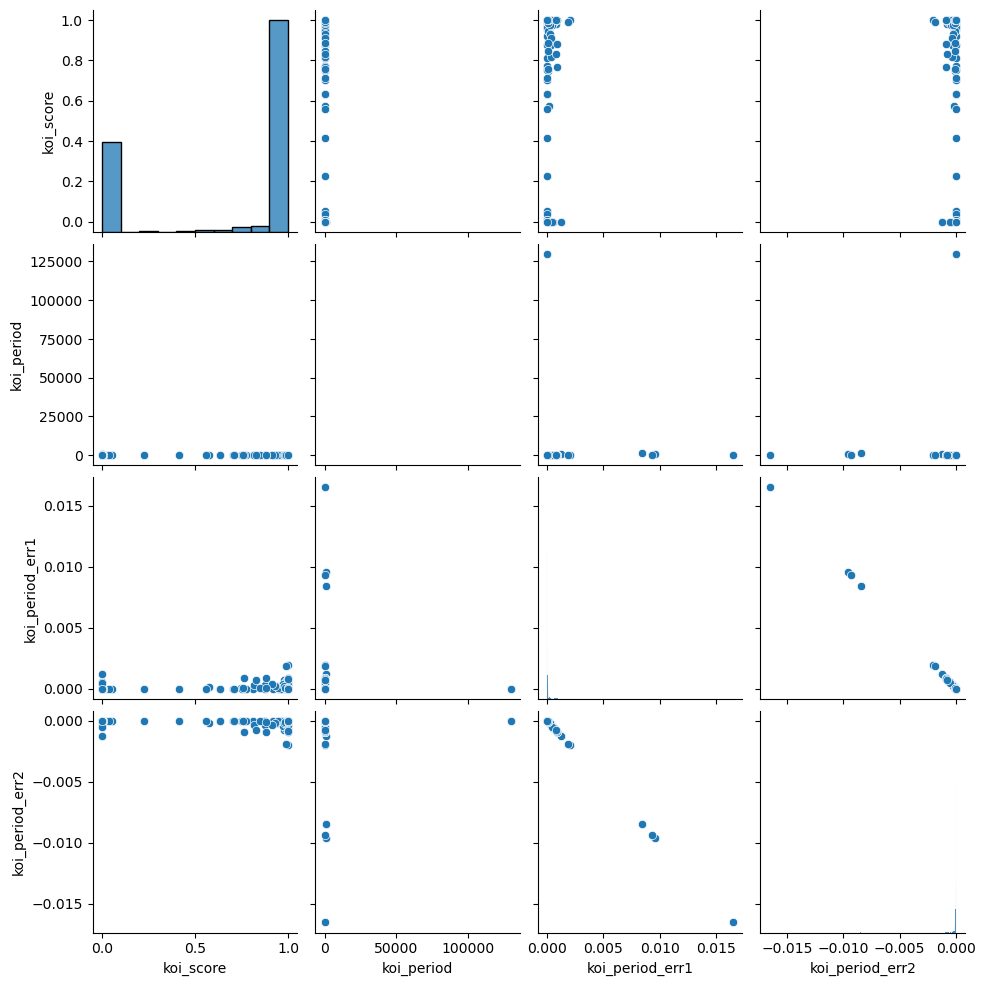

In [10]:
sns.pairplot(viz_data3)

### Cleaning

The data variables are split into categories on the NASA website. Underneath each catefory name we have entered the name of the list that contains the variable names belonging to this category.

KOI = "Kepler Object of Interest" <br>
KIC = "Kepler Input Catalog"

| Category | List Name | Description |
|:---------|:---------:|:------------|
|Identification Columns|id_vars|KOI Id and name|
|Exoplanet Archive Information|arch_vars|Archival records of KOI "dispositions" (classifications)|
|Project Disposition Columns|disp_vars|Kepler Project-informed "disposition" (classification) metadata|
|Transit Properties|tran_vars|Kepler Project derived features derived for classification assignment|
|Threshold-Crossing Event (TCE) Information|tce_vars|Features describing signal to noise ratio of measurements which are based on "planet transit" events.|
|Stellar Parameters|stel_vars|Describe star|
|KIC Parameters|kic_vars|Various brigtness measure of the star using differend bands in units of magnitude.|
|Pixel-Based KOI Vetting Statistics|pix_vars|Pixel level feature engineering to reduce transit false positives|

In [11]:
# Listing column names belonging to each category
id_vars = ["kepid", "kepoi_name"]

arch_vars = ["kepler_name", "koi_disposition", "koi_vet_stat", "koi_vet_date"]

disp_vars = ["koi_pdisposition", "koi_score", "koi_fpflag_nt",
             "koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec",
             "koi_disp_prov", "koi_comment"]

tran_vars = ["koi_period", "koi_time0bk", "koi_time0", "koi_eccen",
             "koi_longp", "koi_impact", "koi_duration", "koi_ingress",
             "koi_depth", "koi_ror", "koi_srho", "koi_fittype", 
             "koi_prad", "koi_sma", "koi_incl", "koi_teq", "koi_insol",
             "koi_dor", "koi_limbdark_mod", "koi_ldm_coeff1",
             "koi_ldm_coeff2", "koi_ldm_coeff3", "koi_ldm_coeff4",
             "koi_parm_prov"]

tce_vars = ["koi_max_sngle_ev", "koi_max_mult_ev", "koi_model_snr",
            "koi_count", "koi_num_transits", "koi_tce_plnt_num",
            "koi_tce_delivname", "koi_quarters", "koi_trans_mod",
            "koi_model_dof", "koi_model_chisq", "koi_datalink_dvr",
            "koi_datalink_dvs"]

stel_vars = ["koi_steff", "koi_slogg", "koi_smet", "koi_srad",
             "koi_smass", "koi_sage", "koi_sparprov"]

kic_vars = ["ra", "dec", "koi_kepmag", "koi_gmag", "koi_rmag",
            "koi_imag", "koi_zmag", "koi_jmag", "koi_hmag", "koi_kmag"]

pix_vars = ["koi_fwm_sra", "koi_fwm_sdec", "koi_fwm_sdec", 
            "koi_fwm_srao", "koi_fwm_sdeco", "koi_fwm_prao",
            "koi_fwm_pdeco", "koi_fwm_stat_sig", "koi_dicco_mra",
            "koi_dicco_mdec", "koi_dicco_msky", "koi_dikco_mra",
            "koi_dikco_mdec", "koi_dikco_msky"]

## Model Building

In [23]:
replace_map = {'CANDIDATE':1, 'FALSE POSITIVE':0}

nasa_data.koi_pdisposition=nasa_data.koi_pdisposition.map(replace_map)

In [24]:
#Removing koi_tce_delivname
data_vars = ["koi_max_sngle_ev", "koi_max_mult_ev", "koi_model_snr",
            "koi_count", "koi_num_transits", "koi_tce_plnt_num",
            "koi_quarters", "koi_trans_mod",
            "koi_model_dof", "koi_model_chisq", "koi_datalink_dvr",
            "koi_datalink_dvs", "koi_steff", "koi_slogg", "koi_smet", "koi_srad",
             "koi_smass", "koi_sage", "koi_sparprov", "ra", "dec", "koi_kepmag", "koi_gmag", "koi_rmag",
            "koi_imag", "koi_zmag", "koi_jmag", "koi_hmag", "koi_kmag", "koi_fwm_sra", "koi_fwm_sdec", "koi_fwm_sdec", 
            "koi_fwm_srao", "koi_fwm_sdeco", "koi_fwm_prao",
            "koi_fwm_pdeco", "koi_fwm_stat_sig", "koi_dicco_mra",
            "koi_dicco_mdec", "koi_dicco_msky", "koi_dikco_mra",
            "koi_dikco_mdec", "koi_dikco_msky"]

x = [col for col in nasa_data.columns if col in data_vars]
y = [col for col in nasa_data.columns if col in tran_vars]

#store = nasa_data["koi_pdisposition"]

nasa_standard = nasa_data

#nasa_standard = (nasa_data - nasa_data.mean())/nasa_data.std()

#nasa_standard.koi_pdisposition=store

X = nasa_standard[x]

X = (X-X.mean())/X.std()

In [26]:
X

,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
0,-0.281595,-0.366632,-0.316020,0.362554,-0.130845,-0.026420,1.202701,0.781259
1,-0.294161,1.138094,-0.316020,0.362554,-0.130845,-0.026420,1.202701,0.781259
2,-0.230703,-0.366632,0.183441,0.540545,-0.140474,1.037343,1.200612,0.845498
3,0.308750,-0.366632,0.123205,0.586777,-0.153041,-1.369000,1.242565,0.961706
4,-0.275186,-0.366632,0.406819,0.295519,-0.111423,-0.693417,1.226179,0.898189
...,...,...,...,...,...,...,...,...
9559,-0.316025,-0.366632,-0.086368,-0.032724,-0.104569,1.403299,0.878285,0.154025
9560,0.243030,-0.366632,-0.086368,0.505872,-0.134762,1.075929,0.911737,-0.131803
9561,-0.313261,-0.366632,0.517252,0.309388,-0.113871,-1.164504,0.931008,0.355404
9562,-0.311125,-0.366632,0.585019,0.316323,-0.112239,0.441552,0.934635,0.808687


In [41]:
with pm.Model() as logistic_model:
    Y = nasa_standard.koi_pdisposition
    α = pm.Normal('α', mu=0, sigma=100) 
    β1 = pm.Normal('β1', mu=0, sigma=100) 
    β2 = pm.Normal('β2', mu=0, sigma=100)
    β3 = pm.Normal('β3', mu=0, sigma=100)
    β4 = pm.Normal('β4', mu=0, sigma=100)
    β5 = pm.Normal('β5', mu=0, sigma=100)
    β6 = pm.Normal('β6', mu=0, sigma=100)
    β7 = pm.Normal('β7', mu=0, sigma=100)
    β8 = pm.Normal('β8', mu=0, sigma=100)
    μ = α + β1*X.koi_model_snr+β2*X.koi_tce_plnt_num+β3*X.koi_steff+β4*X.koi_slogg+β5*X.koi_srad+β6*X.ra+β7*X.dec+β8*X.koi_kepmag
    p = pm.Deterministic('p',  pm.invlogit(μ))
    Yl = pm.Bernoulli('Yl', p=p, observed=Y)
    #binout = pm.sample(1000, tune=2000) #init="adapt_diag"
    
pm.model_to_graphviz(logistic_model)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'α': array(1.), 'β1': array(1.), 'β2': array(1.), 'β3': array(1.), 'β4': array(1.), 'β5': array(1.), 'β6': array(1.), 'β7': array(1.), 'β8': array(1.)}

Initial evaluation results:
α    -5.52
β1   -5.52
β2   -5.52
β3   -5.52
β4   -5.52
β5   -5.52
β6   -5.52
β7   -5.52
β8   -5.52
Yl    -inf
Name: Log-probability of test_point, dtype: float64

In [29]:
X

,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
0,-0.281595,-0.366632,-0.316020,0.362554,-0.130845,-0.026420,1.202701,0.781259
1,-0.294161,1.138094,-0.316020,0.362554,-0.130845,-0.026420,1.202701,0.781259
2,-0.230703,-0.366632,0.183441,0.540545,-0.140474,1.037343,1.200612,0.845498
3,0.308750,-0.366632,0.123205,0.586777,-0.153041,-1.369000,1.242565,0.961706
4,-0.275186,-0.366632,0.406819,0.295519,-0.111423,-0.693417,1.226179,0.898189
...,...,...,...,...,...,...,...,...
9559,-0.316025,-0.366632,-0.086368,-0.032724,-0.104569,1.403299,0.878285,0.154025
9560,0.243030,-0.366632,-0.086368,0.505872,-0.134762,1.075929,0.911737,-0.131803
9561,-0.313261,-0.366632,0.517252,0.309388,-0.113871,-1.164504,0.931008,0.355404
9562,-0.311125,-0.366632,0.585019,0.316323,-0.112239,0.441552,0.934635,0.808687


In [42]:
# Matrix version of the model

with pm.Model() as logistic_model:
    Y = nasa_standard.koi_pdisposition
    k =  X.shape[1]
    α = pm.Normal('α', mu=0, sigma=100)
    # Beta coefficients for predictor variables & priors
    β = pm.MvNormal('β', mu=np.zeros(k), cov=100*np.eye(k), shape=k)
    μ = α + pm.math.dot(X,β)
    p = pm.Deterministic('p',  pm.invlogit(μ))
    # Model error
    #sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)

    Yl = pm.Bernoulli('Yl', p=p, observed=Y)
    #Yl = pm.Normal('Yl', mu=μ, sd=sigma_y, observed=Y)
    #binout = pm.sample(1000, tune=2000) #init="adapt_diag"
    
#pm.model_to_graphviz(logistic_model)
logistic_model.check_test_point()
#Xlog = 1/(1+np.exp(-1*X))
#Xlog

α    -0.92
β    -7.35
Yl    -inf
Name: Log-probability of test_point, dtype: float64

In [ ]:
az.plot_trace(binout, compact = False, var_names = ['α','β1','β2','β3','β4','β5','β6','β7','β8','β9'], figsize = (18,15));

In [ ]:
# summary statistics on the posterior distributions

az.summary(binout, var_names = ['α', 'β1', 'β2','β3','β4','β5','β6','β7','β8','β9'])